# Imports

In [37]:
import sys
sys.path.insert(1, '../')
from genesis import *

In [38]:
# pd.options.display.max_rows = 300

In [40]:
universe = ASIA_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [122]:
s = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=130,
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=130,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=260)

# Signal 

In [165]:
## SG - Value investing in fixed income, currencies and commodities, pp16 (CM signal)
sig = total_price_usd[universe].ffill().\
          pipe(norm, 252).\
          pipe(demean_xs).\
          pipe(cap_helper, 2.5).\
          pipe(rolling_mean, 5) * -1

In [181]:
sig = spot_price_usd[universe].ffill().\
          pipe(norm, 252).pipe(zscore, 252).\
          pipe(demean_xs).\
          pipe(cap_helper, 2.5).\
          pipe(rolling_mean, 5) * -1

In [182]:
b = Backtest(signal = sig, asset_returns = total_returns, tcost = abs(total_returns*0), settings = s)
b.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [183]:
bt_obj = b

In [184]:
get_summary(bt_obj)

Returns   : 0.035189103918812796
Vol       : 0.11182644865706824
SR        : 0.31467603899972896
Max DD    : -26.91
Hit rate  : 0.512
W | N | L : 0.51 | 0.0 | 0.49
W/L Ratio : 1.05


In [185]:
get_returns_stats(bt_obj.asset_rtn, b.wts)

,USDSGD,USDTHB,USDTWD,USDKRW,USDPHP,USDINR,USDIDR,USDMYR,USDCNH
annualized_return,0.943504,1.373101,0.659397,0.308215,-0.261338,-0.505371,-0.052384,0.022084,0.525488
sharpe,0.177008,0.237847,0.10807,0.08555,-0.094024,-0.185315,-0.014509,0.008224,0.166008
dollar_sharpe,0.163777,0.212233,0.07395,0.071191,-0.11084,-0.198097,-0.033364,-0.005018,0.143335
trade_sharpe,0.177008,0.237847,0.10807,0.08555,-0.094024,-0.185315,-0.014509,0.008224,0.166008
long_sharpe,-0.441208,-0.925528,-0.050458,0.005365,0.064965,-0.404685,-0.422108,-0.192757,0.661888
short_sharpe,0.852207,1.274217,0.259306,0.274721,-0.3338,-0.124653,0.524077,0.185313,-0.018271
sortino,0.087841,0.129171,0.061714,0.034291,-0.041483,-0.078772,-0.005326,0.003481,0.037421
max_drawdown,-20.346602,-23.365253,-20.481562,-14.56055,-11.361162,-12.405992,-10.846466,-17.14864,-18.948974
max_drawdown_start,2002-06-18,2004-09-28,2003-09-23,2008-07-09,2008-07-10,2012-06-22,2010-08-02,2011-05-23,2014-04-29
max_drawdown_end,2004-07-28,2004-12-03,2006-12-05,2010-11-23,2013-05-08,2016-12-28,2015-01-30,2016-01-08,2015-09-01


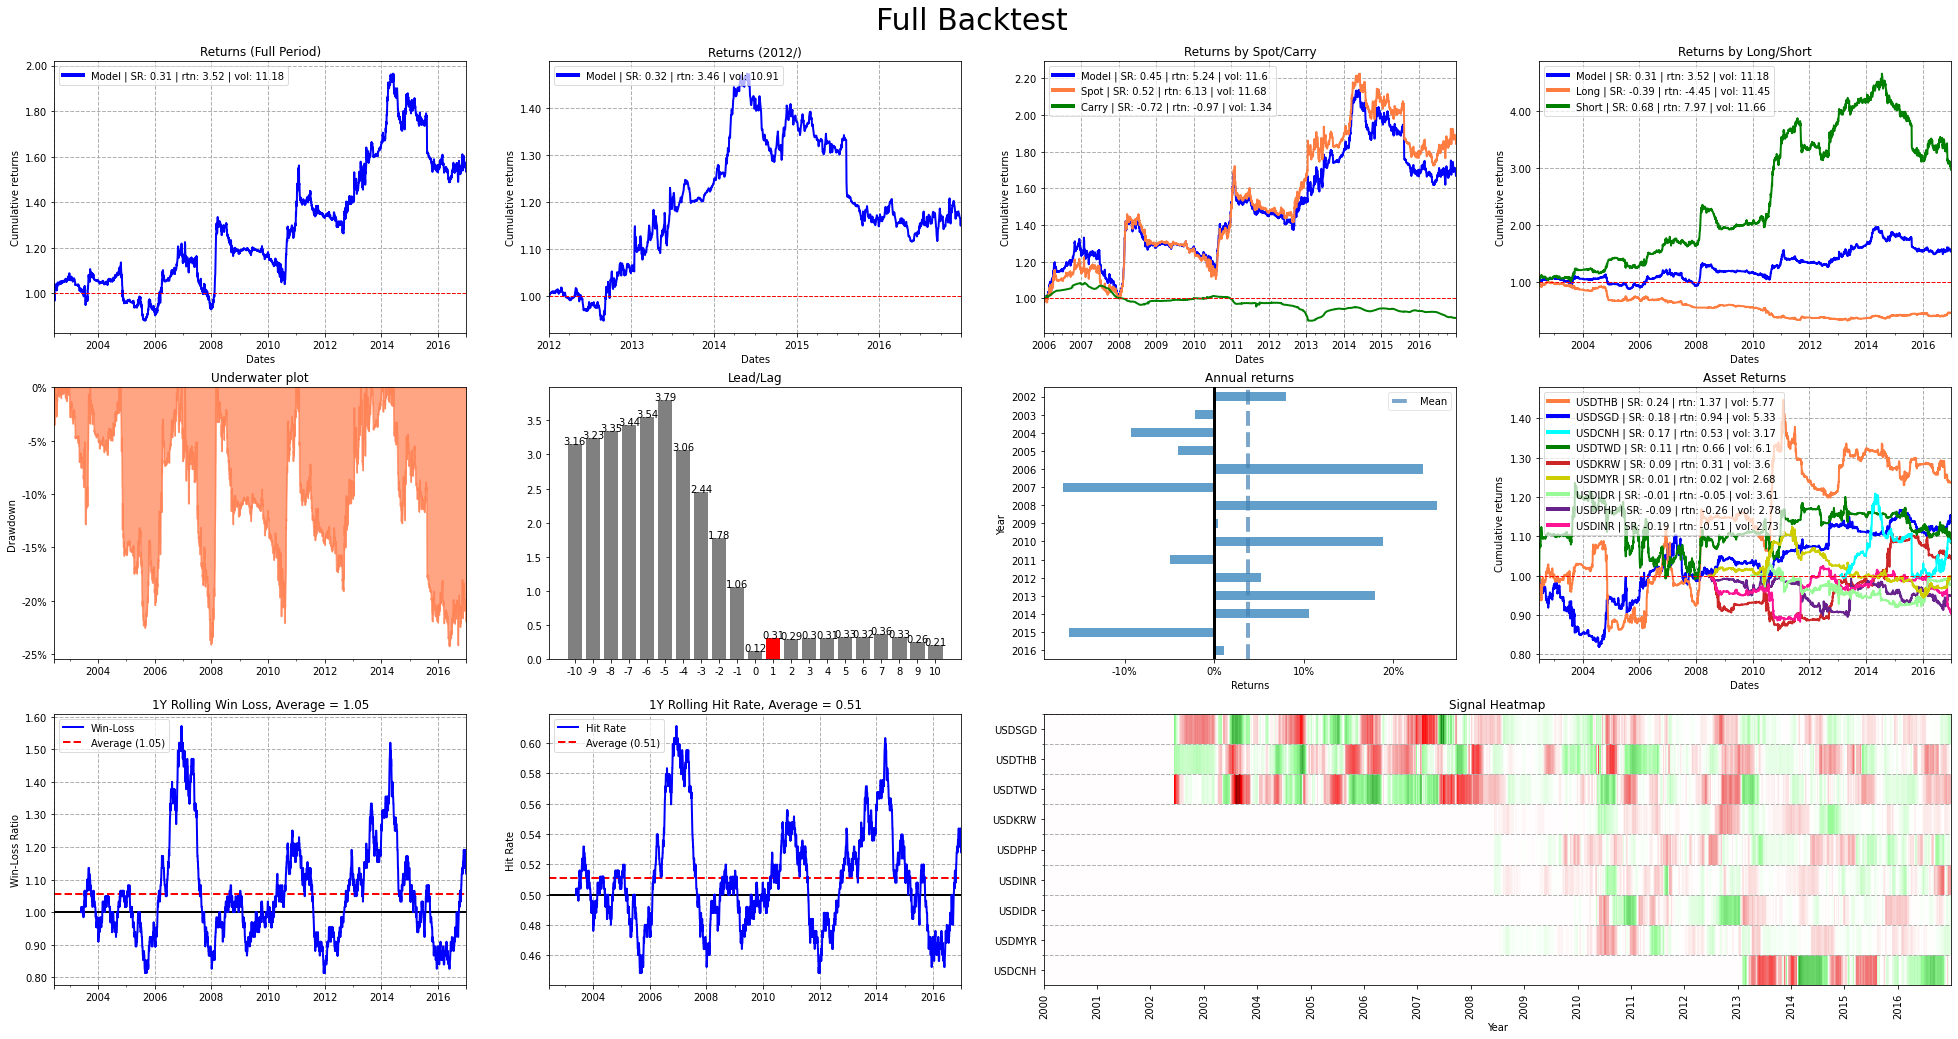

In [186]:
plot_bt(bt_obj)

In [ ]:
pf.plot_monthly_returns_dist(bt_obj.model_rtn)

In [ ]:
gs = GridSpec(nrows = 2, ncols = 2)
fig = plt.figure(figsize=(20, 15))
fig.suptitle(t="Full Backtest", fontsize=30, y=.925)

fig.add_subplot(gs[0]).set_label(gen_plot_rtn(bt_obj.model_rtn, main = "Returns (Full Period)"))
fig.add_subplot(gs[1]).set_label(gen_rtn_asset(bt_obj))
fig.add_subplot(gs[2]).set_label(pf.plot_drawdown_underwater(bt_obj.model_rtn))
fig.add_subplot(gs[3]).set_label(gen_rtn_longshort(bt_obj))

In [ ]:
# gen_rtn_longshort(bt_obj)
# gen_rtn_component(bt_obj, spot_rtns, carry_rtns)
# gen_leadlag(b, nlag=20)
# gen_rolling_hitrate(bt_obj.model_rtn)
# gen_rolling_winloss(bt_obj.model_rtn)
# pf.plot_monthly_returns_dist(bt_obj.model_rtn)
# pf.plot_annual_returns(bt_obj.model_rtn)
# gen_signal(bt_obj)
# gen_rtn_asset(bt_obj)
# gen_plot_rtn(bt_obj.model_rtn["2012":])
# gen_rolling_sharpe(bt_obj.model_rtn)
# gen_rtn_col_component(bt_obj, spot_rtns, carry_rtns)
# gen_rtn_col_longshort(bt_obj)

In [ ]:
def band_filter(series):
  return series.applymap(lambda x: 1 if x < -1.5 else -1 if x > 1.5 else 0)

def hold_position(series):
  tmp = np.sign(series).diff()
  return pd.Series([np.nan if y == 0 else x for x,y in zip(series, tmp.diff())], index = tmp.index).ffill()

binary = spot_returns.pipe(zscore, 252*5).pipe(band_filter)
mag = abs(spot_returns.pipe(zscore, 252*5)) * binary
sig = mag.apply(hold_position)